In [152]:
from gpxcsv import gpxtolist
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from folium import Map
from folium.plugins import HeatMap
import utm
from matplotlib.animation import FuncAnimation
from scipy.stats import gaussian_kde

%matplotlib notebook
#%matplotlib inline
ox.config(log_console=True)
ox.__version__





'1.0.1'

In [130]:
def GPScoordinates_to_utm(lat,lon):
    """" Function that projects the GPS coordinates in degrees (latitude, longitude) into the UTM coordinate system
    in order to work with the concept of "point" and "Euclidean distance" in a plane.
    (https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
    
    Note: We are dealing with locations in the same area/region. Otherwise, we should be careful if two locations 
    belong to different UTM zones when calculating distances, etc. 
    
    Input:
        - lists of GPS coordinates: latitude and longitude
        
    Output:
        - lists of the UTM projections of the GPS coordinates: 
        - The utm package returns Easting, Northing, Zone_number and Zone_letter. So we only store the two first elements
    """
    
    lat_utm=[]
    lon_utm=[]
    for i in range(len(lat)):
        u=utm.from_latlon(lat[i],lon[i])  # get the UTM projection
        lat_utm.append(u[0])   # Store the projection of latitude and longitude in lists
        lon_utm.append(u[1])
        
    return lat_utm, lon_utm
        
    

def EuclidianDistance(x1,y1,x2,y2):
    """ Function that returns the distance in metres between 2 points in a p(NO GPS locs.) 
    
    Note: Be careful as the GPS coordinates (lat,lon) cannot be used, but their projections to a plane (e.g. utm projection).

    
    Input:
        - The coordinates of two points in a plane: (x1,y1) and (x2,y2).
        
    Output:
        - Euclidian distance in metres between the two points.
    """
    Euclidian_distance = ( (x2-x1)**2 + (y2-y1)**2 ) ** 0.5
        
    return Euclidian_distance
        
    
        
def getDistanceFromLatLonInM(lat1,lon1,lat2,lon2):
    """ Function that returns the distance in metres between 2 GPS locations in degrees (latitude and longitude).
    It is based in the Haversine formula (https://en.wikipedia.org/wiki/Haversine_formula) which takes into account the
    Earth's curvature. 
    
    Input:
        - 2 GPS coordinates: (latitude1,longitude1) of the first point and (latitude2,longitude2) of the second point. 
        
    Output:
        - Distance in metres between the two GPS locations.
    """
    
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)  # Diference between latitudes in radians
    dLon = radians(lon2-lon1) # Diference between longitudes in radians
    rLat1 = radians(lat1)   # Latitudes in radians
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    e= d*1000 # Distance in m
   
    return e
   
    
    
def instantaneous_velocity(distance,time):
    """" Function that computes the instantenous velocity between two points, given their distance and their time difference.
    
    Input:
        - Distance between two points or two locations
        - Time difference between the two points/locations
        
    Output:
        - Instantenous velocity between the two points
    """
    
    v=distance/time
    
    return v


def convert(seconds):
    """" Function that converts the seconds to hours, minuts and seconds
    
    Input:
        - Number of seconds
        
    Output:
        - Hours, minuts and seconds
    """
    
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return hour, minutes, seconds


def map_network(latitude, longitude, dist):
    """" Function that creates a map of the urban network in a given radius around a gps location.
    
    Input:
        - latitude and longitude (GPS coordinates)
        - dist: distance (radius) from which the network is constructed
        
    Output:
        - The figure and the axes.
        
    """
    
    G = ox.graph_from_point((latitude, longitude), dist, network_type='all')   # Create the graph from lat and lon
    fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor="#333333",edge_color="w", edge_linewidth=0.8, node_size=0)

    return fig, ax
    



def RadiusOfGyration(x,y):
    """" Function that computes the radius of gyration of a 2-d trajectory with x and y coordinates.
    
    M. C. Gonzalez, C. a C. A. Hidalgo, A. L. A.-L. Barabási, M. C. González, C. A. H. 
    & A.-L. B. Marta C. González, and M. C. Gonz, Nature 453, 779 (2008).
    
    Note: x,y coordinates can't be lat,lon in degrees. Before we must project them into a plane (e.g UTM projection)
    
    
    Input:
        - Lists of coordinates x and y
    
    Output:
        - Radius of gyration
    """
    
    r_cm_x=sum(x)/len(x)
    r_cm_y=sum(y)/len(y)
    
    radius2=[]
    for i in range(len(x)):
        r_new_x=x[i]-r_cm_x
        r_new_y=y[i]-r_cm_y
        radius2.append((r_new_x*r_new_x) + (r_new_y*r_new_y))
    
    mean_radius2=sum(radius2)/len(radius2)
    
    rg=mean_radius2**0.5
    
    return rg
        
    
        

            

def vector(latitude0,longitude0,latitude1,longitude1): 
    """ Given two points returns the vector from the origin point to destination. If GPS coordinates, use UTM projection.
    
    Input:
        - Coordinates of origin point (p0x,p0y) and destionation point (p1x, p1y).
    
    Oputput:
        - Coordinates of the vector from p0 to p1. 
    """
    
    p0=(latitude0,longitude0)   
    p1=(latitude1,longitude1)
    vec=(p1[0]-p0[0], p1[1]-p0[1]) 
    return vec


def determinant(vec0,vec1):
    """  Returns determinant of two vectors. If det<0 means that the second vector has turned in the clockwise direction.
    
    Input:
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
        
    Output:
        - Determinant of two vectors. If det<0 the second vector has turned in the clockwise direction respect to the first.
    """
    det=vec0[0]*vec1[1]-vec0[1]*vec1[0]
    return det

# Obtain the angle between two consecutive vectors (change in orientation, reorientation, turning angle).
# This angle is <0 if det<0 (clockwise) and >0 if counter clockwise
def reorientation(vec0,vec1):
    """Returns the angle between two consecutive vectors (change in orientation, reorientation, turning angle)
    The range is from -pi to +pi. If det<0 the second vector has turned in the clockwise direction and therefore the 
    reorientation angle is also <0. On contrary, if has turned counter-clockwise is >0. 
    
    Input: 
        - Two consecutive vectors (vec0, vec1) characterized with their x,y coordinates.
    
    Output:
        - Reorientation angle between them 
    """
    unit_vec0=vec0/np.linalg.norm(vec0)
    unit_vec1=vec1/np.linalg.norm(vec1)
    dot_product=np.dot(unit_vec0,unit_vec1)
    a=np.arccos(dot_product)
    det=determinant(vec0,vec1)
    if det<0:
        return -a
    else:
        return a

    
        
def turtuosity(latitudes,longitudes):
    """ Given the two lists of latitudes and longitudes (utm projection), it returns the turtuosity of the trajectory. 
    If turtuosity is near 0 means that the trajectory is very straight to the final destionation. If its near to 1 means that
    is the movement is very turtuous (not direct).
    
    Input:
        - Lists of x and y points (latitudes and longitudes projected) of a trajectory.
        
    Output:
        - Estimation of the turtuosity of the trajectory.
    """

    vectors=[]
    vectors_straight=[]
    for i in range(1,len(latitudes)):
        vectors.append(vector(latitudes[i-1],longitudes[i-1],latitudes[i],longitudes[i]))  # Vector between the point i-1 and  i.
        vectors_straight.append(vector(latitudes[i-1],longitudes[i-1],latitudes[-1],longitudes[-1]))  # straight vector between  
                                                                                         # point i and final point (destination)
        
    reorientations=[]   
    for i in range(len(vectors)-1):
        reorientations.append(np.cos(abs(reorientation(vectors_straight[i],vectors[i])))) # Reorientation angle 
        #reorientations2 = [x for x in reorientations if np.isnan(x) == False]  # avoid nan values                                                                           # vector and the straight vector (>=0)
            
    turtuo=1.-(sum(reorientations)/len(reorientations))  # The average value of the movement re-orientations gives the effiency
                                                         # of the trajectory (how straightforward/directed is towards the final
                                                         # destionation. Then 1 - effiency is the turtuosity
            
    return turtuo

    1- We read all the .gpx files in the folder
    2- We plot the trajectories in a map.
    3- We compute the total distance travelled, the amount of time spent, the mean instantenous velocity, the radious of gyration and the turtuosity.
    4- We create a HeatMap depending on the velocities.
    5- We create a HeatMap of the GPS positions
    6- We create a HeatMap of the GPS positions using Folium, with Zoom for a better visualisation.

<IPython.core.display.Javascript object>


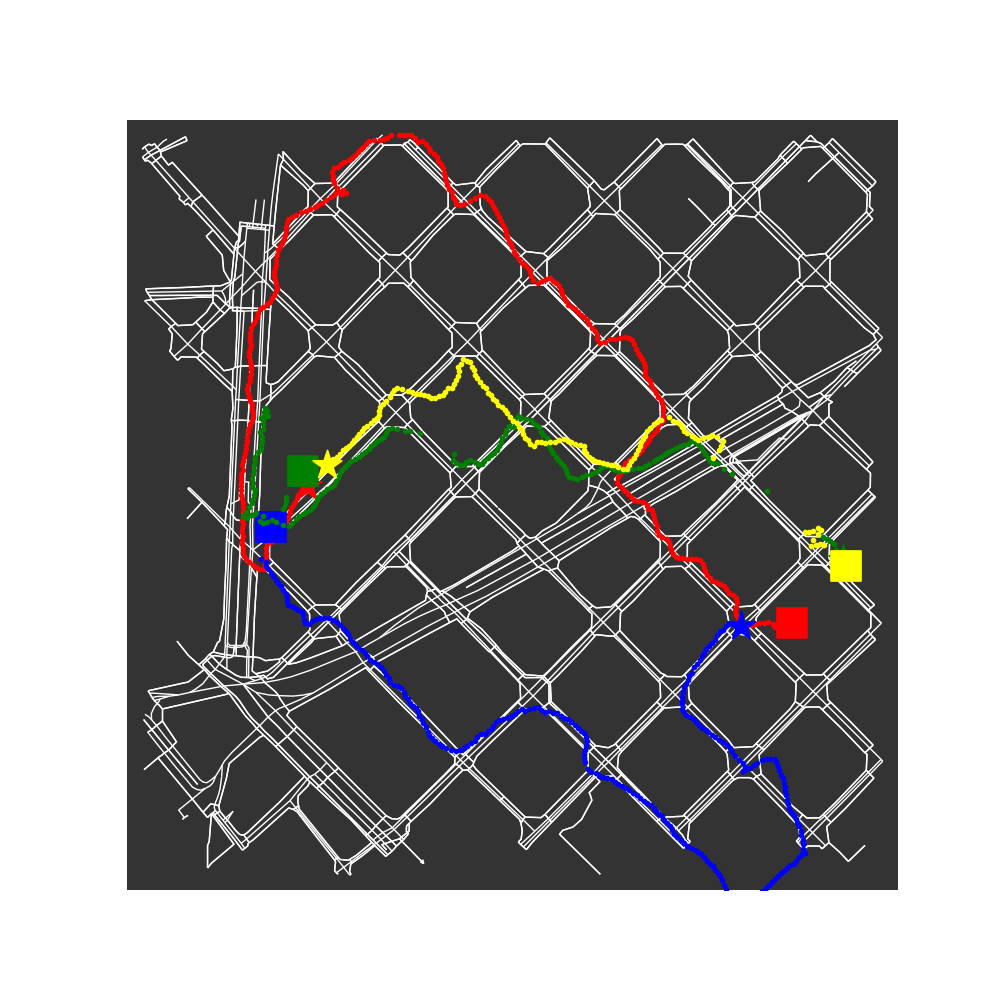

Grup: caminada1.gpx

La durada total del trajecte és de: 0.0 hores  23.0 minuts  i  14.0 segons

La distància total recorreguda és de: 1959.1186554245462 metres

La velocitat mitjana és de: 1.5315347425666999 m/s  std: 0.5521571303335867 m/s
La velocitat mitjana és de: 5.513525073240119 km/h  std: 1.9877656692009122 km/h

El radi de gir és de: 313.71083433890055 m

La turtuositat és de: 0.6531681945679044

-------------------------------------------
Grup: caminada2.gpx

La durada total del trajecte és de: 0.0 hores  19.0 minuts  i  17.0 segons

La distància total recorreguda és de: 1610.6959628329646 metres

La velocitat mitjana és de: 1.5342563161279887 m/s  std: 0.7371860162287049 m/s
La velocitat mitjana és de: 5.5233227380607595 km/h  std: 2.653869658423338 km/h

El radi de gir és de: 261.8007678792785 m

La turtuositat és de: 0.5882955204483832

-------------------------------------------
Grup: comprar-i-pelu.gpx

La durada total del trajecte és de: 0.0 hores  29.0 minuts  i  33.0

<IPython.core.display.Javascript object>


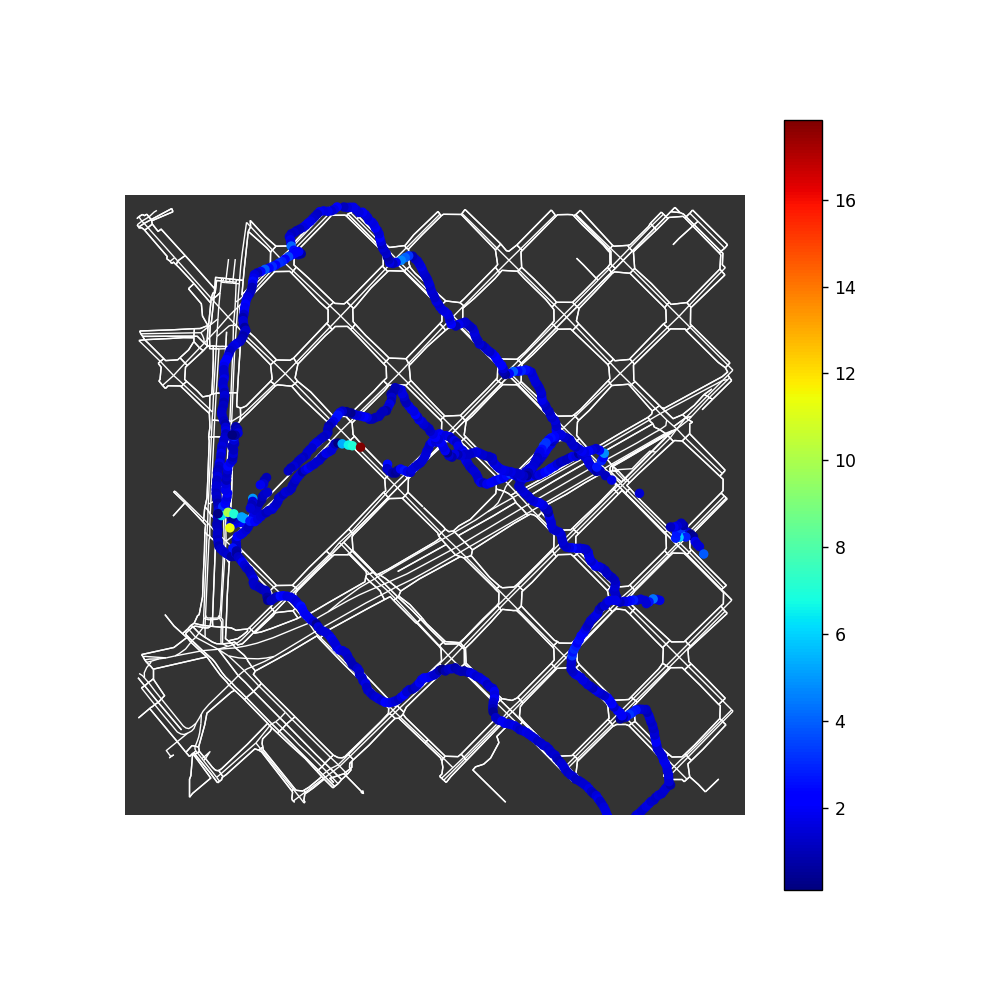



HEATMAP GPS POSITIONS


<IPython.core.display.Javascript object>


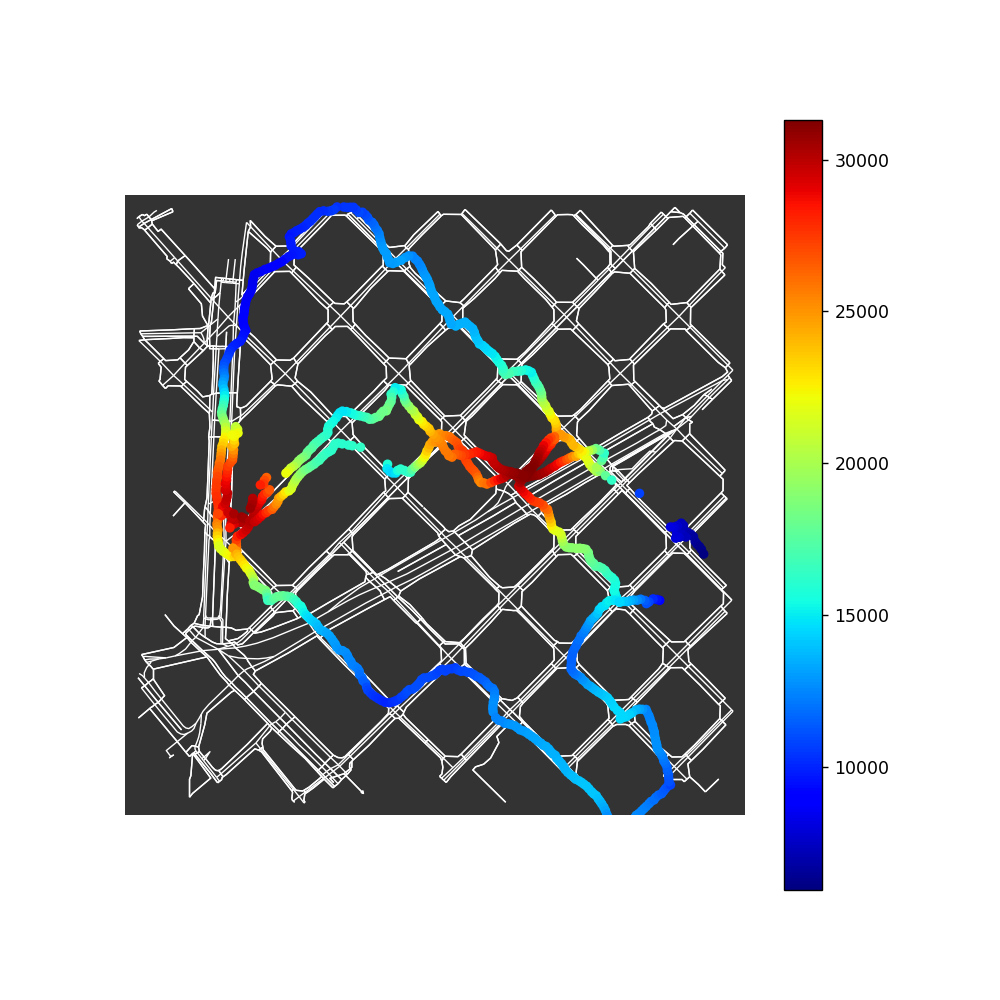



HEATMAP GPS POSITIONS


In [158]:
fig, ax = map_network(41.38279266639305, 2.14680426698555, 500 )  # Create the graph from a given latitude and longitude

all_files = glob.glob(os.path.join("*.gpx")) # Make list of paths in order to read all the .gpx files in the folder.


list_colors=['red','blue','green','yellow','purple']  # List of colors for each trajectory (each file)
j=0

latitud_tots=[]  # Initialise list for all the latitudes and longitudes
longitud_tots=[]
velocity_all=[]
time=[]

for file in all_files:   # Loop over all gpx files in the folder/directory  
    
    df = pd.DataFrame(gpxtolist(file)) # Read each gpx file and put it into a pandas DataFrame 
    
    print('Grup:', file)
    print('')
    
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')  # Correct format for the time (datetime)
    
    temps=df['time'].tolist()
    lat=df['lat'].tolist()  # Time, Latitude and Longitude to lists
    lon=df['lon'].tolist()
    lat_utm, lon_utm=GPScoordinates_to_utm(lat,lon)  # UTM projections of the Latitude and Longitud lists
    
    latitud_tots.extend(lat)  # Store the latitude and longitude lists for each gile in a common list
    longitud_tots.extend(lon)
    t = np.linspace(0, len(lat)-1, len(lat))  # For the HeatMap
    time.extend(t)

    
    # Plot the coordinates of each trajectory in the street network, with a given color.
    ax.scatter(lon, lat,c=list_colors[j],s=5) # Scatter the GPS locs. with a given color from the list of colors
    ax.scatter(lon[0], lat[0], marker='s', c=list_colors[j],s=300) # Scatter the starting point with a big a square
    ax.scatter(lon[-1], lat[-1], marker='*', c=list_colors[j],s=300) # Scatter the last point with a big star

    j=j+1
    
    
    #STATISTICS. Now we obtain the time difference, the distance and the instantenous velocity between each Geo-location.
    # The calculation is made "in advance". That is, the time difference at the point "i" is  AT(i)=t(i+1)-t(i). So the AT
    # at point N does not exist (considering N points in the trajectory).
        
    
    
    # TIME DIFFERENCE.
    diff_time=[]
    for i in range(1,len(df['time'])):
        diff=temps[i]-temps[i-1]
        diff_time.append(diff)
    
     # Obviuosly, if there are N times, there will be N-1 times differences. So we need to add a NaN value at the end of 
     # the list to store it as a new column of the DataFrame. 
    
    diff_time.insert(len(diff_time), np.nan)  # Obviuosly, if there are N times, there will be N-1 times differences.
    
    df['At']=diff_time   # Store it as a new column in the data frame and transform the difference into total seconds.
    df['At']=df['At'].dt.seconds
    
    t=df['At'][:-1].tolist()  # Time difference (AT) in seconds into list (disregarding the last element, NaN)
    total_seconds_trajectory=sum(t)
    hours, minutes, seconds=convert(total_seconds_trajectory)
    print('La durada total del trajecte és de:', hours, 'hores','', minutes,'minuts','','i','', seconds, 'segons')
    print('')
    
    
    # DISTANCE.
    distance=[]
    for p in range(1,len(lat)):
        dist=getDistanceFromLatLonInM(lat[p-1],lon[p-1],lat[p],lon[p])
        distance.append(dist)        
    print('La distància total recorreguda és de:', sum(distance), 'metres')
    print('')
    
    
    # INSTANTANEOUS VELOCITY.
    velocity=[]
    for k in range(len(distance)):
        velocity.append(instantaneous_velocity(distance[k],t[k]))
    
    mean = sum(velocity) / len(velocity)
    variance = sum([((x - mean) ** 2) for x in velocity]) / len(velocity)
    res = variance ** 0.5
    print('La velocitat mitjana és de:', mean, 'm/s', '', 'std:',res, 'm/s')
    print('La velocitat mitjana és de:', 3.6*mean,'km/h','', 'std:',3.6*res ,'km/h')
    print('') 
    velocity.insert(len(velocity), np.nan) 
    velocity_all.extend(velocity)

    # RADIUS OF GYRATION.   
    Rg=RadiusOfGyration(lat_utm, lon_utm)
    print('El radi de gir és de:', Rg, 'm')
    print('')
    
    # TURTUOSITY
    turto=turtuosity(lat_utm,lon_utm)
    print('La turtuositat és de:', turto)
    print('')
    print('-------------------------------------------')
    

plt.show()


# HEATMAP WITH OSMNX USING VELOCITIES.
print('HEATMAP DEPENDING ON VELOCITIES')

fig, ax = map_network(41.38279266639305, 2.14680426698555, 500 )

df_tots = pd.DataFrame(            
    {'velocitats': velocity_all,
     'latitud': latitud_tots,
     'longitud': longitud_tots,
     'temps':time
    })

v=df_tots['velocitats'].tolist()
lat=df_tots['latitud'].tolist()
lon=df_tots['longitud'].tolist()
sss=ax.scatter(lon, lat, c=v, cmap='jet',s=20)
fig.colorbar(sss, ax=ax)
#ax.set_title('SGV')
plt.show()

print('')
print('')

# HEATMAP WITH OSMNX USING POSITIONS.
print('HEATMAP GPS POSITIONS')
fig, ax = map_network(41.38279266639305, 2.14680426698555, 500 )
# Calculate the point density
xy = np.vstack([lat,lon])
z = gaussian_kde(xy)(xy)

sss=ax.scatter(lon, lat, c=z, cmap='jet',s=20)
fig.colorbar(sss, ax=ax)

plt.show()

print('')
print('')


# HEAT MAP WITH ALL GPS LOCATIONS (FROM ALL THE FILES) FOLIUM
print('HEATMAP GPS POSITIONS')
for_map = Map(location=[41.38279266639305, 2.14680426698555], zoom_start=15, )
hm_wide = HeatMap(
    list(zip(latitud_tots, longitud_tots)),
    min_opacity=0.2,
    radius=17, 
    blur=15, 
    max_zoom=1,
)

for_map.add_child(hm_wide)
    

# Animation of trajectories

<IPython.core.display.Javascript object>


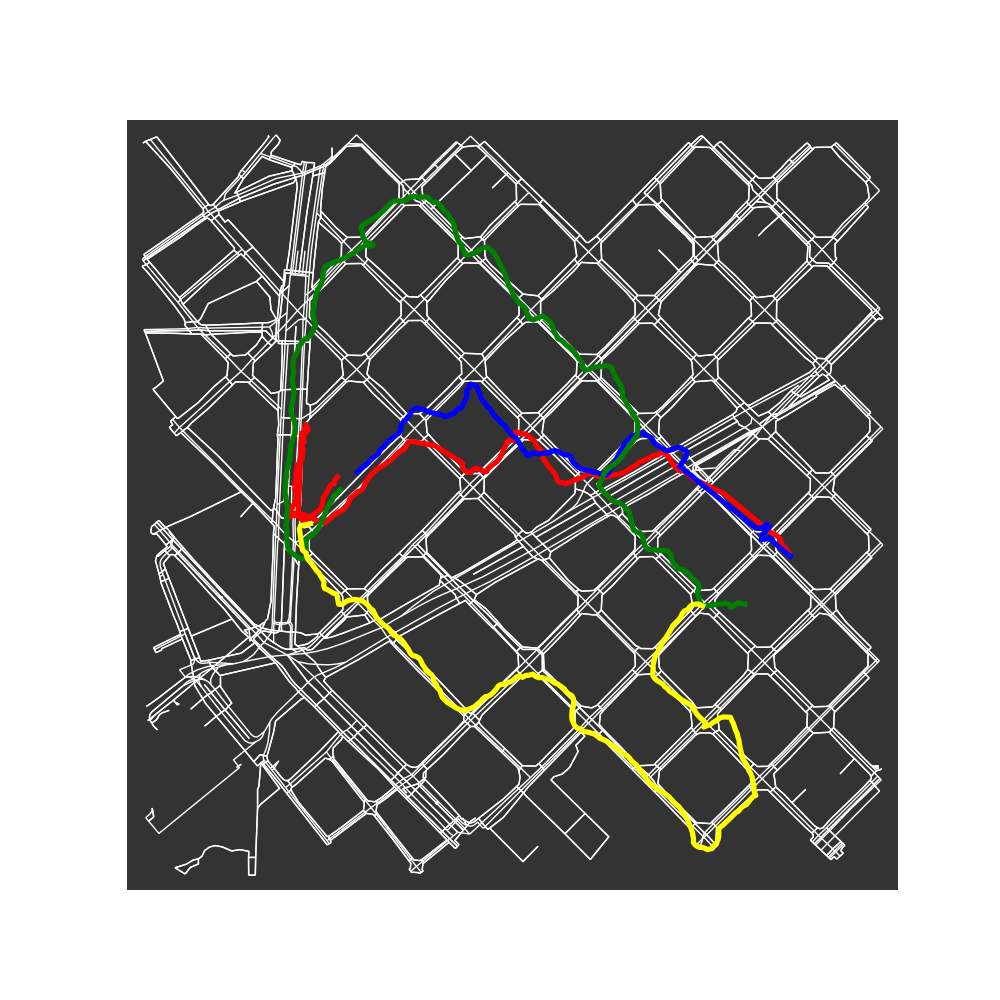

In [131]:
c=4   # number of trajectories

df1 = pd.DataFrame(gpxtolist('comprar-i-pelu.gpx'))
df2 = pd.DataFrame(gpxtolist('tornada-pelu-a-casa.gpx'))    # each individual trajectory (.gpx file)
df3 = pd.DataFrame(gpxtolist('caminada1.gpx'))
df4 = pd.DataFrame(gpxtolist('caminada2.gpx'))

list_dfs=[df1,df2,df3,df4]

fig, ax = map_network(41.38279266639305, 2.14680426698555, 600 )  # initialise the map
list_colors=['red','blue','green','yellow','purple']          # colors for the trajectories
lines = [plt.plot([], [], '-',c=list_colors[j],linewidth=3)[0] for j in range(c)]


# With this code, we create the animation video of the trajectories in df1 and df2

def init():
    m = 0
    while m < c:
        lines[m].set_data([], [])          
        m+=1
    return lines

   
def update(i):
    n=-1
    while n<c:
        n+=1
        df=list_dfs[n]
        lines[n].set_data(df.iloc[0:i, 1], df.iloc[0:i, 0])
    return lines   #edited in 


anim = FuncAnimation(fig, update, init_func=init, frames=500, interval=70, blit=True,repeat=True)

plt.show()